# 1D regression following "AllYouNeedIsFunctionalPriors" paper

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import logging

# set up logging to file
logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s',
     datefmt='%H:%M:%S'
 )


In [3]:
import torch
from torch import nn

import numpy as np
import math
import matplotlib.pylab as plt

In [4]:
import datetime
import os 

In [5]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

In [6]:
import sys
sys.path.append("../")

In [7]:
import targets_gp
import import_export
import utils

from train_priors_and_activations import main_parameterized as train_priors
from metrics import compute_distribution_distances

In [8]:
from bnn import SingleHiddenLayerWide1DRegressionNNWithGaussianPriors

## Config

In [9]:

# prior learning
train_prior = True
train_prior_n_iterations = 2001
train_prior_num_function_samples = 512  # = n_data=200 from the AllYouNeed notebook
train_prior_batch_size = 512

# posterior learning
net_width = 128
posterior_mcmc_n_samples = 200
posterior_mcmc_num_chains = 1  # you cannot use more than 1 in notebooks

# regression model params
sn2 = 0.1   # noise variance
likelihood_scale = math.sqrt(sn2)


## Init

In [10]:

prior_str = "trained_priors" if train_prior else "default_priors"
target_dir = f"../pretrained/e2e_allyouneed_1D_regression_{prior_str}_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_prefix = target_dir + "/"

print(f"Saving results to target_dir = {target_dir}")

if target_dir is not None and target_dir != "":
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

Saving results to target_dir = ../results/e2e_allyouneed_1D_regression_trained_priors_20241014161924


In [11]:
_, dtype = utils.setup_torch()

python/lib/python3.8/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
[16:19:24] {../utils.py:35} INFO - [setup_torch] Using CPU
[16:19:24] {../utils.py:40} INFO - [setup_torch] #threads=16


## Aux from AllYouNeed repo

In [12]:
def zscore_normalization(X, mean=None, std=None, eps=1e-10):
    """Apply z-score normalization on a given data.

    Args:
        X: numpy array, shape [batchsize, num_dims], the input dataset.
        mean: numpy array, shape [num_dims], the given mean of the dataset.
        var: numpy array, shape [num_dims], the given variance of the dataset.

    Returns:
        tuple: the normalized dataset and the resulting mean and variance.
    """
    if X is None:
        return None, None, None

    if mean is None:
        mean = np.mean(X, axis=0)
    if std is None:
        std = np.std(X, axis=0)

    X_normalized = (X - mean) / (std + eps)

    return X_normalized, mean, std


def zscore_unnormalization(X_normalized, mean, std):
    """Unnormalize a given dataset.

    Args:
        X_normalized: numpy array, shape [batchsize, num_dims], the
            dataset needs to be unnormalized.
        mean: numpy array, shape [num_dims], the given mean of the dataset.
        var: numpy array, shape [num_dims], the given variance of the dataset.

    Returns:
        numpy array, shape [batch_size, num_dims] the unnormalized dataset.
    """
    return X_normalized * std + mean


def unnormalize_predictions(pred_mean, pred_var, y_mean, y_std):
    """Unnormalize the regression predictions.

    Args:
        pred_mean: np.array, [n_data, 1], the predictive mean.
        pred_var: np.array, [n_data, 1], the predictive variance.
        y_mean: np.array, [n_data, 1], the mean estimated from training data.
        y_std: np.array, [n_data, 1], the std estimated from training data.        
    """
    pred_mean = zscore_unnormalization(pred_mean, y_mean, y_std)
    pred_var = pred_var * (y_std ** 2)

    return pred_mean, pred_var

In [13]:
def util_set_seed(seed=99):
    """Set seed for reproducibility purpose."""
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

In [14]:
def rmse(y_pred, y):
    """Calculates the root mean squared error.

    Args:
        y_pred: numpy array, shape [batch_size], the predictions.
        y: numpy array, shape [batch_size], the corresponding labels.

    Returns:
        rmse: float, the resulting root mean squared error.
    """
    y_pred, y = y_pred.squeeze(), y.squeeze()
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))

    return float(rmse)

## Data

In [15]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

In [16]:
util_set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)

In [17]:
print("Normalize the dataset (normalized values have _ suffix)")
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)

Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)
Xtest_tensor_ = torch.from_numpy(Xtest_)

print("Transformations in X:", X_mean, X_std)
print("Transformations in Y:", y_mean, y_std)

Normalize the dataset (normalized values have _ suffix)
Transformations in X: [3.89738198] [4.53119575]
Transformations in Y: [-0.06547381] [1.26164173]


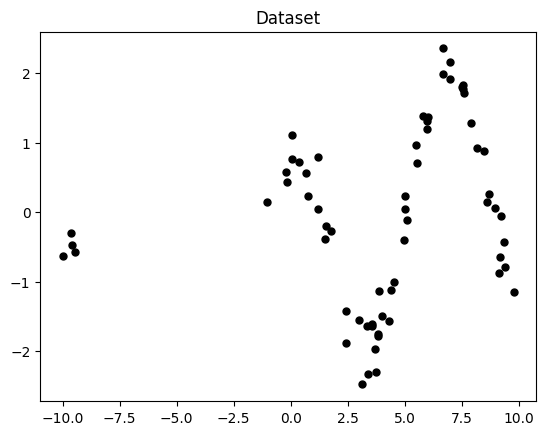

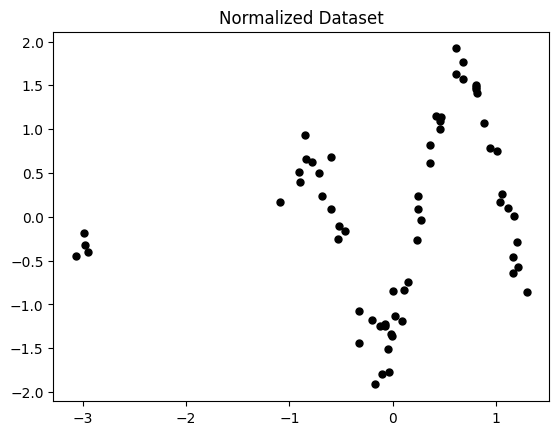

In [18]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

fig = plt.figure()
plt.plot(X_, y_, "ko", ms=5)
plt.title("Normalized Dataset")
plt.show()

## Targets

In [19]:
gpmodel = targets_gp.AllYouNeed1DRegression()

tensor(-4.1705, dtype=torch.float64) tensor(2.4503, dtype=torch.float64) <=> -15.0 15.0 <=> -4.170506646416837 2.4502622789372936


../baselines/you_need_a_good_prior/optbnn/gp/parameter.py:63: UserWarning: An output with one or more elements was resized since it had shape [1], which does not match the required output shape []. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:35.)
  return torch.log(torch.exp(t) - 1, out=out)
../baselines/you_need_a_good_prior/optbnn/gp/models/model.py:119: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmet

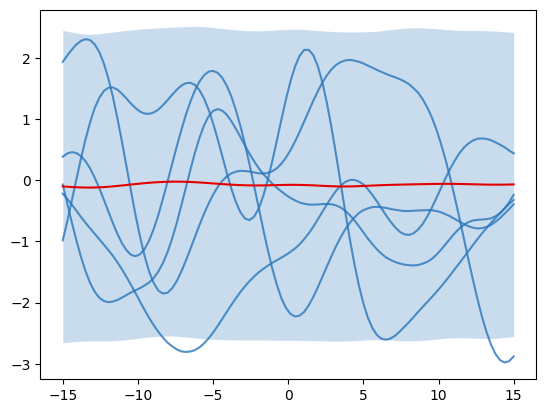

<Figure size 640x480 with 0 Axes>

In [20]:
# Draw functions from the priors
n_plot = 4000
util_set_seed(8)

print(Xtest_tensor_.min(), Xtest_tensor_.max(), "<=>", Xtest.min(), Xtest.max() , "<=>", Xtest_.min(), Xtest_.max())

gp_samples = gpmodel(Xtest_tensor_, n_plot).detach().cpu().numpy().squeeze()
gp_samples = zscore_unnormalization(gp_samples, y_mean, y_std)

# for comparison
evaluation_batch = torch.from_numpy(gp_samples).T

plot_samples(Xtest, gp_samples, ax=plt.gca(), n_keep=5)
# plt.savefig(results_prefix+"target_gp_samples.png")
plt.show()
plt.clf();

## Training priors

In [21]:
fit = train_priors(
    config_set_no=1001,  # AllYouNeed setting from 1D_regression_gaussian_priors.ipynb
    n_iterations=train_prior_n_iterations, 
    uniform_training_grid=False,  # AllYouNeed they have True
    num_function_samples=train_prior_num_function_samples,  
    batch_size=train_prior_batch_size,  
    activation="nnsilu_1_5", 
    run_name=results_prefix+"prior_fit", 
    force_recomputing=True,
    bnn_width=net_width,
    )

[16:19:25] {../train_priors_and_activations.py:331} INFO - Configuration: {'run_name': '../results/e2e_allyouneed_1D_regression_trained_priors_20241014161924/prior_fit', 'generator_width': 1000, 'bnn_width': 128, 'loss_func': <function wasserstein_distance at 0x7f97e9f09310>, 'create_parameter_sampler': <function create_factorized_sampler_gaussian_zero_loc at 0x7f97e9f24f70>, 'activation': 'nnsilu_1_5', 'n_iterations': 2001, 'lr': 0.01, 'report_every_n_iterations': 200, 'config_set_no': 1001, 'priors_config_set_no': None, 'input_type': 'sampled_grid', 'input_n_dims': 1, 'batch_size': 512, 'num_function_samples': 512, 'shuffle_xs_n_times': 1, 'uniform_training_grid': False, 'freeze_training_grid': False, 'final_evaluation_on_training_grid': False, 'final_evaluation_batch_size': 1024, 'final_evaluation_num_function_samples': 512, 'random_seed': None, 'test_grid_n_nodes': None, 'description': {}, 'force_recomputing': True, 'results_path': '../results/e2e_allyouneed_1D_regression_trained_p

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

<Figure size 1280x320 with 0 Axes>

Xtest_ vs Xtest = -15.0, 15.0 vs. -4.170506646416837, 2.4502622789372936
compute_distribution_distances = {'1-Wasserstein': 6.27688605346486, '2-Wasserstein': 6.4597426201813795, 'Linear_MMD': -0.3420582339276996, 'Poly_MMD': -0.9536916518941325, 'RBF_MMD': 0.0023981231311882567, 'Mean_MSE': 0.0005624931586417526, 'Mean_L2': 0.023716938222328628, 'Mean_L1': 0.01829810040468612, 'Median_MSE': 0.0015934436137595473, 'Median_L2': 0.0399179610421117, 'Median_L1': 0.03138550008314754}


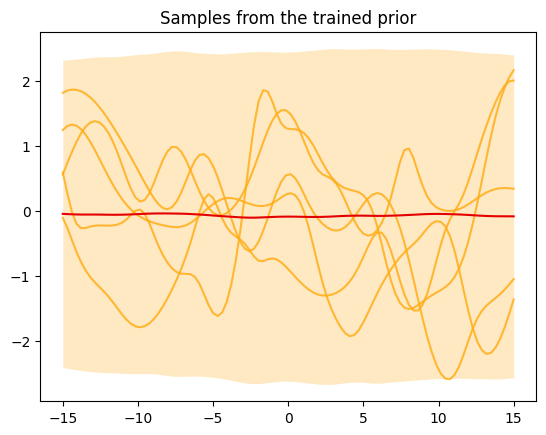

<Figure size 640x480 with 0 Axes>

In [22]:
# Note use of Xtest_ vs Xtest
print(f"Xtest_ vs Xtest = {Xtest.min()}, {Xtest.max()} vs. {Xtest_.min()}, {Xtest_.max()}")

net = fit["posterior_predictive"]
# net_samples = torch.stack([net(torch.tensor(Xtest_, dtype=dtype)) for _ in range(512)])
net_samples = torch.stack([net(torch.tensor(Xtest_, dtype=dtype)) for _ in range(n_plot)])
net_samples = net_samples.squeeze(-1).T
net_samples = net_samples.cpu().detach().numpy()
net_samples = zscore_unnormalization(net_samples, y_mean, y_std)

prediction_batch = torch.from_numpy(net_samples).T

# comparison
metrics = compute_distribution_distances(prediction_batch, evaluation_batch)
print(f"compute_distribution_distances = {metrics}")

plot_samples(Xtest, net_samples, ax=plt.gca(), color='xkcd:yellowish orange', n_keep=5)
plt.title("Samples from the trained prior")
# plt.savefig(results_prefix+"prior_samples.png")
plt.show()
plt.clf();

## Finding posterior

[10:43:56] {../bnn/bnn_regression_pyro.py:18} INFO - [SingleHiddenLayerWide1DRegressionNNWithGaussianPriors] Using priors parameters = {'layer1.weight': Normal(loc: 0.0, scale: 0.39048221707344055), 'layer1.bias': Normal(loc: 0.0, scale: 2.4443445205688477), 'layer2.weight': Normal(loc: 0.0, scale: 0.633269190788269), 'layer2.bias': Normal(loc: 0.0, scale: 0.05695803463459015), 'activation': NNActivation(
  (activation): SiLU()
  (fci): Linear(in_features=1, out_features=5, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
  )
  (fco): Linear(in_features=5, out_features=1, bias=True)
)}.


Creating a BNN from parameters = {'layer1.weight': Normal(loc: 0.0, scale: 0.39048221707344055), 'layer1.bias': Normal(loc: 0.0, scale: 2.4443445205688477), 'layer2.weight': Normal(loc: 0.0, scale: 0.633269190788269), 'layer2.bias': Normal(loc: 0.0, scale: 0.05695803463459015), 'activation': NNActivation(
  (activation): SiLU()
  (fci): Linear(in_features=1, out_features=5, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
  )
  (fco): Linear(in_features=5, out_features=1, bias=True)
)}


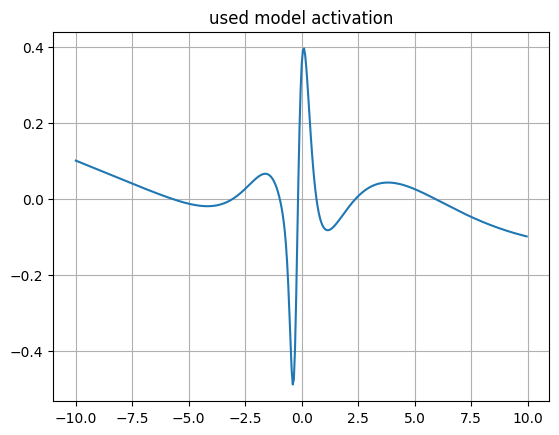

Sampling from prior predictive


python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fco.weight

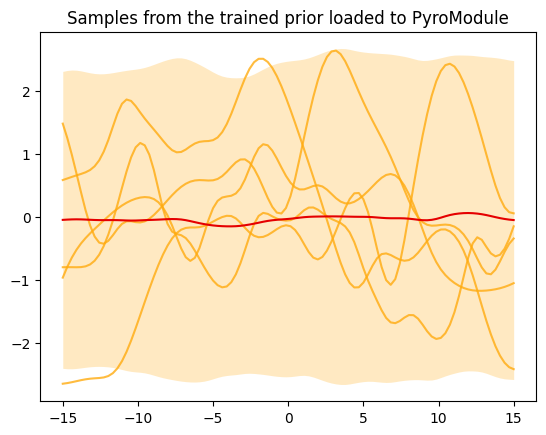

<Figure size 640x480 with 0 Axes>

In [23]:
# Set Pyro random seed
pyro.set_rng_seed(41)

if train_prior:
    parameters = import_export.import_parameters(fit["parameters"], target_net_width=net_width)
    
else:
    parameters = {  
          "layer1.weight": dist.Normal(0., 1.),
          "layer1.bias": dist.Normal(0., 1.),
          "layer2.weight": dist.Normal(0., 1. / np.sqrt(net_width)),
          # "layer2.weight": dist.Normal(0., 1.),  # NOTE: uncomment to enable overconfidence for ReLU !!!
          "layer2.bias": dist.Normal(0., 1.),
          "activation": nn.Tanh(),                        
        }

print(f"Creating a BNN from parameters = {parameters}")
bnn_model = SingleHiddenLayerWide1DRegressionNNWithGaussianPriors(
    net_width=net_width,
    parameters=parameters,
    likelihood_scale=likelihood_scale
    )

############################################################################

plt.plot(torch.arange(-10, 10, 0.05), bnn_model.activation(torch.arange(-10, 10, 0.05)))
plt.grid(True)
plt.title("used model activation");
# plt.savefig(results_prefix+"model_activation.png")
plt.show()
plt.clf()

############################################################################
print("Sampling from prior predictive")

def prior_predictive_sampling(model, input_tensor, num_samples=119):
    predictive = pyro.infer.Predictive(model, num_samples=num_samples)
    samples = predictive(input_tensor)
    return samples

samples = prior_predictive_sampling(bnn_model, Xtest_tensor_.type(dtype), num_samples=512)
net_samples = samples["mu"].squeeze(1).T
net_samples = zscore_unnormalization(net_samples, y_mean, y_std)

plot_samples(Xtest, net_samples, ax=plt.gca(), color='xkcd:yellowish orange', n_keep=5)
plt.title("Samples from the trained prior loaded to PyroModule")
# plt.savefig(results_prefix+"prior_samples_pyro.png")
plt.show()
plt.clf();

In [24]:
print("Posterior training is done on normalized data")
train_x, train_y = torch.tensor(X_, dtype=dtype), torch.tensor(y_, dtype=dtype) 

print(f"train_x ({train_x.shape}) = [{train_x.min()}, {train_x.max()}], "
      f"train_y ({train_y.shape}) = [{train_y.min()}, {train_y.max()}]")

Posterior training is done on normalized data
train_x (torch.Size([64, 1])) = [-3.066540241241455, 1.2976353168487549], train_y (torch.Size([64, 1])) = [-1.9124243259429932, 1.9204555749893188]


In [25]:
predictive = Predictive(model=bnn_model, num_samples=111)
preds = predictive(train_x, train_y.type(dtype))

print("Predictive log likelihood shape:", preds["log_likelihood"].shape)
print("Predictive log likelihood of the training data: [TODO fix aggregation]", preds["log_likelihood"].mean())

print("RMSE", torch.math.sqrt(((preds["mu"].squeeze(1).mean(0).unsqueeze(-1)-train_y)**2).mean()))

Predictive log likelihood shape: torch.Size([111, 1, 64])
Predictive log likelihood of the training data: [TODO fix aggregation] tensor(-9.7693)
RMSE 0.9929938756613671


In [26]:
# Define Hamiltonian Monte Carlo (HMC) kernel

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(bnn_model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get MC posterior samples
mcmc = MCMC(nuts_kernel, num_samples=posterior_mcmc_n_samples, num_chains=posterior_mcmc_num_chains) #, disable_validation=True)

# Run MCMC
mcmc.run(train_x, train_y)

# Print summary statistics
mcmc.summary(prob=0.8)  # This gives you the 80% credible interval by default

predictive = Predictive(model=bnn_model, posterior_samples=mcmc.get_samples())
preds = predictive(train_x, train_y.type(dtype))

print("Predictive log likelihood shape:", preds["log_likelihood"].shape)
print("Predictive log likelihood of the training data: [TODO fix aggregation]", preds["log_likelihood"].mean())

print("RMSE", torch.math.sqrt(((preds["mu"].squeeze(1).mean(0).unsqueeze(-1)- train_y)**2).mean()))

Warmup:   0%|          | 0/400 [00:00, ?it/s]python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/py


                          mean       std    median     10.0%     90.0%     n_eff     r_hat
      layer1.bias[0]     -0.01      2.28     -0.24     -2.71      3.07    107.16      1.00
      layer1.bias[1]      0.75      2.40      0.82     -1.61      4.09     95.10      1.01
      layer1.bias[2]     -0.10      2.69     -0.17     -2.81      3.57    154.54      1.00
      layer1.bias[3]      0.22      2.47      0.32     -2.20      3.93    177.63      1.00
      layer1.bias[4]      0.02      2.31     -0.09     -3.08      2.60    186.24      1.00
      layer1.bias[5]      0.07      2.21      0.01     -2.74      2.78    154.64      1.01
      layer1.bias[6]      0.23      2.43     -0.07     -2.71      3.59    100.11      1.00
      layer1.bias[7]     -0.15      2.67     -0.17     -4.24      2.57    169.10      1.00
      layer1.bias[8]      0.06      2.42     -0.26     -3.08      2.54    134.99      1.00
      layer1.bias[9]     -0.27      2.37     -0.33     -2.64      3.16    123.72      1.0

Posterior predictive on normalized test_grid = torch.Size([100, 1])
Unnormalize X and y (net_samples=torch.Size([100, 200])) for plotting posterior predictve


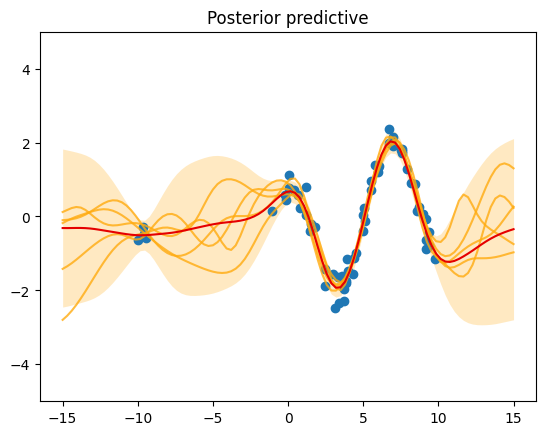

<Figure size 640x480 with 0 Axes>

In [27]:
test_grid = Xtest_tensor_
print(f"Posterior predictive on normalized test_grid = {test_grid.shape}")
predictive = Predictive(model=bnn_model, posterior_samples=mcmc.get_samples())
samples = predictive(test_grid.type(dtype))

net_samples = samples["mu"].squeeze(1).T

print(f"Unnormalize X and y (net_samples={net_samples.shape}) for plotting posterior predictve")
net_samples = zscore_unnormalization(net_samples, y_mean, y_std)
test_grid_unnormalized = zscore_unnormalization(test_grid, X_mean, X_std)

plot_samples(test_grid_unnormalized, net_samples, ax=plt.gca(), color='xkcd:yellowish orange', n_keep=5)
plt.scatter(X, y)  # plot unnormalized data
plt.ylim(-5, 5)
plt.title("Posterior predictive")
# plt.savefig(results_prefix+"posterior_samples_pyro.png")
plt.show()
plt.clf();